In [19]:
#To import required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ttp import ttp
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import re

In [3]:
#to inite spark session
spark = SparkSession.builder.appName("keyWords").config("spark.master", "local").getOrCreate()

In [8]:
#To import the data using read function, include header, reterive schema, and separate data by \t
file_path = "tweets_dataset_v2.csv"
tweetsDF = spark.read.csv(file_path, header=True, inferSchema=True, sep=",")
tweetsDF.printSchema()
tweetsDF.show(5)

root
 |-- _c0: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- label: string (nullable = true)
 |-- numberOfAnnotators: string (nullable = true)

+---+--------------------+---+-------+------------------+
|_c0|                text| id|  label|numberOfAnnotators|
+---+--------------------+---+-------+------------------+
|  0|Beats by Dr Dre u...|  1|   spam|                 4|
|  1| Man it would fuc...|  2|abusive|                 4|
|  2|It is time to dra...|  3| normal|                 4|
|  3|if you notice me ...|  4| normal|                 5|
|  4|Forget unfollower...|  5| normal|                 3|
+---+--------------------+---+-------+------------------+
only showing top 5 rows



In [25]:
#To create an a temprory view from the tweetsDF and get the text column only
tweetsDF.createOrReplaceTempView("tweets")
query = spark.sql("SELECT text FROM tweets WHERE NOT label='normal'")

In [26]:
#To get the text only, we removed links, username, and hashtags using regex
text_list = []

for t in query.select("text").collect():
    rtxt = (' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",str(t.text)).split())).lstrip("RT")
    if (rtxt != ""):
        text_list.append(rtxt.lower())
print(len(text_list))

47358


{'very', "you're", "don't", "wasn't", 'doing', 'no', "she's", 'a', "they've", 'both', 'why', 'all', 'itself', 'did', 'and', 'him', 'at', 'you', 'ours', 'out', 'when', 'an', 'being', 'can', 'having', 'been', 'your', 'or', 'under', "we'd", "where's", 'my', 'would', 'for', "shan't", 'not', 'hence', 'however', 'above', 'just', 'through', 'is', 'he', "hasn't", "doesn't", "we've", 'me', 'but', 'with', 'k', "i'd", 'get', 'up', 'her', 'yourselves', 'like', 'after', 'only', "there's", 'were', "we're", 'also', 'this', 'else', 'some', 'in', "let's", 'more', 'myself', "weren't", 'nor', 'am', "couldn't", 'was', 'com', "isn't", 'our', 'themselves', 'ought', 'of', "shouldn't", 'have', "you've", 'so', 'from', 'there', 'are', "hadn't", 'into', 'we', 'i', "she'd", "what's", 'most', "he'll", 'that', 'hers', 'its', "she'll", 'which', "they're", "won't", 'further', 'by', 'each', 'herself', 'where', "you'd", 'yourself', 'the', 'because', 'over', "i'm", "wouldn't", 'about', 'www', 'had', 'on', 'before', 'to'

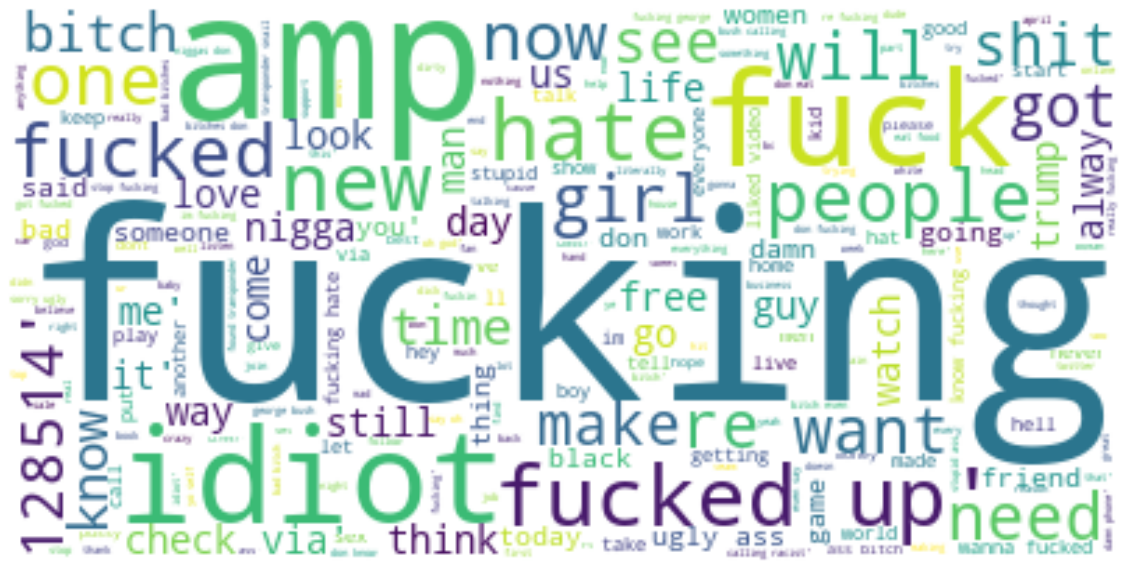

In [59]:
#To generate words clouds to show the most populr key-words in the dataset

#Get stop words to remove them from text
stopwords = set(STOPWORDS)
print(stopwords)
wordcloud = WordCloud(max_font_size= 500, stopwords = stopwords, max_words=40000,contour_width=3, background_color="white").generate(str(text_list))
plt.figure(figsize=[20,40])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

+-------+--------------+
|  label|numberOSTweets|
+-------+--------------+
| normal|         52636|
|abusive|         26825|
|   spam|         13908|
|hateful|          4848|
+-------+--------------+



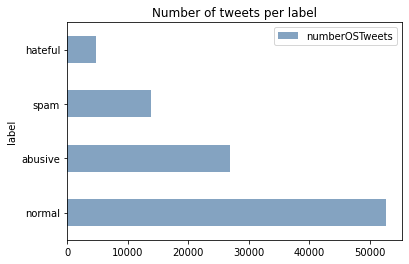

In [38]:
query2 = spark.sql("SELECT label, COUNT(label) AS numberOSTweets FROM tweets GROUP BY label ORDER BY numberOSTweets DESC LIMIT 4")

query2.show()

# Convert to Pandas DataFrame  
df_pandas = query2.toPandas()

# Create a horizontal bar plot
df_pandas.plot(kind='barh', x='label', y='numberOSTweets', color=(0.2, 0.4, 0.6, 0.6))
plt.title("Number of tweets per label")
plt.show()

In [56]:
#To import the data using read function, include header, reterive schema, and separate data by \t
file_path = "only_hashtags.csv"
tagsDF = spark.read.csv(file_path, header=True, inferSchema=True, sep="\t")
tagsDF.printSchema()
tagsDF.show(5)

root
 |-- tweet_id: double (nullable = true)
 |-- hashtag: string (nullable = true)

+--------+-----------+
|tweet_id|    hashtag|
+--------+-----------+
|     8.0|      heart|
|     8.0|     cancer|
|    15.0|       TOTP|
|    22.0| Kyrgyzstan|
|    22.0|     Kyrgyz|
+--------+-----------+
only showing top 5 rows



+-------------------+-----+
|            hashtag|total|
+-------------------+-----+
|             TreCru|  481|
|                job|  218|
|         NowPlaying|  186|
|           giveaway|  170|
|       Wrestlemania|  132|
|               news|  125|
|              quote|  113|
|             hiring|   97|
|         NowOrNever|   96|
|         SoundCloud|   95|
| YouKnowYouLoveThem|   93|
|                 np|   92|
|               jobs|   91|
|       WrestleMania|   86|
|              Trump|   84|
|             Hiring|   76|
|              Syria|   76|
|     interiordesign|   74|
|                win|   73|
|       OneDirection|   67|
+-------------------+-----+



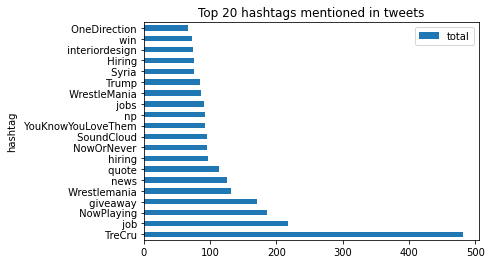

In [58]:
#To create an a temprory view from the tagsDF and get the text column only
tagsDF.createOrReplaceTempView("tags")


#To find top 20 hashtags users have been maentioned in the text
query3 = spark.sql("SELECT hashtag, COUNT(hashtag) AS total FROM tags GROUP BY hashtag ORDER BY total DESC LIMIT 20")

query3.show()

# Convert to Pandas DataFrame  
q3_pandas = query3.toPandas()

# Create a horizontal bar plot
q3_pandas.plot(kind='barh', x='hashtag', y='total',)
plt.title("Top 20 hashtags mentioned in tweets")
plt.show()